# **Detecting Financial Statement Fraud in Vietnam Using Machine Learning: A Proxy-Based Multi-Criteria Labeling Approach via Voting**

### **Information**
- Student Name: Nguyen Huu Kien
- Student ID: K224141670

# SUMMARY
The primary objective of this study is to develop a more comprehensive and accurate machine learning framework for detecting financial reporting fraud among Vietnamese listed companies. By integrating multiple fraud proxies into the labeling process and evaluating a broad range of classification algorithms, the study aims to improve fraud detection performance and address limitations such as label incompleteness and class imbalance commonly found in previous research.

Also, this study builds upon and extends the study of Cuong Nguyen Thanh & Tam Phan Huy (2025), which applied machine learning to detect financial reporting fraud using auditor opinions as fraud proxy. In this study, we inherit the modeling framework and algorithmic comparisons from the prior research, while proposing significant methodological enhancements. Specifically, fraud labeling is expanded to a multi-criteria voting mechanism based on three proxies: (i) post-audit profit deviation (>5%), (ii) abnormal auditor opinions, and (iii) statistical outliers detected via Mahalanobis distance. Observations flagged by any of the three criteria are labeled as fraudulent, allowing for broader fraud detection coverage while mitigating class imbalance.

The dataset is also substantially expanded, covering 6,329 observations from 1,394 non-financial listed firms on HOSE, HNX, and UPCOM during 2020–2024, compared to 2,747 observations in the original study. We reapply a similar set of machine learning algorithms: Logistic Regression, KNN, Naive Bayes, SVM (linear and sigmoid), Decision Tree, Random Forest, ANN, and XGBoost—but under a more robust labeling framework and with updated financial and audit data from FiinPro-X and Vietstock.

The results show marked improvement, with Random Forest and XGBoost achieving AUCs between 0.91 and 0.95, significantly outperforming the original study (maximum AUC = 0.75).  This improvement is not only reflected in AUC but also supported by other performance metrics, indicating consistent effectiveness across multiple evaluation dimensions. Such robustness enhances the reliability of deploying these models in real-world monitoring systems.

## Import data

In [23]:
import pandas as pd
import numpy as np
df = pd.read_excel('raw_data_101.xlsx') 

In [24]:
# 1. Dataset dimensions
print("Dataset shape:", df.shape)

# 2. General info about the dataset
print("\nData info:")
print(df.info())

# 3. Descriptive statistics for numerical features
print("\nDescriptive statistics:")
print(df.describe())

# 4. Data types
print("\nData types count:")
print(df.dtypes.value_counts())

# 5. Object-type columns (usually categorical/text)
object_cols = df.select_dtypes(include='object').columns.tolist()
print("\nObject-type (categorical/text) columns:")
print(object_cols)

# 6. Columns with fewer than 10 unique values (likely categorical)
print("\nColumns with fewer than 10 unique values:")
for col in df.columns:
    if df[col].nunique() < 10:
        print(f"{col}: {df[col].unique()}")

# 7. First 5 rows
print("\nFirst 5 rows:")
print(df.head())

# 8. Last 5 rows
print("\nLast 5 rows:")
print(df.tail())

Dataset shape: (6329, 20)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6329 entries, 0 to 6328
Data columns (total 20 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Mã                                                                 6329 non-null   object 
 1   Tên công ty                                                        6329 non-null   object 
 2   Sàn                                                                6329 non-null   object 
 3   Ngành ICB - cấp 2                                                  6329 non-null   object 
 4   Năm                                                                6329 non-null   int64  
 5   TỔNG CỘNG TÀI SẢN                                                  6329 non-null   float64
 6   NỢ PHẢI TRẢ                                                        6329 non-null  

## Data pre-processing

### Check missing and zeros values

In [25]:
print("STATISTICS OF ZEROS AND NULLS IN EACH COLUMN:")
print("="*50)

# Check each column
for col in df.columns:
    null_count = df[col].isnull().sum()
    zero_count = (df[col] == 0).sum()
    total_rows = len(df)
    
    print(f"Column '{col}':")
    print(f"  - Null count: {null_count} ({null_count / total_rows * 100:.1f}%)")
    print(f"  - Zero count: {zero_count} ({zero_count / total_rows * 100:.1f}%)")
    print(f"  - Total (Zero + Null): {null_count + zero_count} ({(null_count + zero_count) / total_rows * 100:.1f}%)")
    print()

# Overall summary
print("OVERVIEW:")
print(f"Total rows: {len(df)}")
print(f"Total columns: {len(df.columns)}")

# Rows with at least one null or zero value
rows_with_null_or_zero = df.isnull().any(axis=1) | (df == 0).any(axis=1)
print(f"Rows with at least one null or zero: {rows_with_null_or_zero.sum()}")

# Clean rows (no nulls and no zeros)
clean_rows = (~df.isnull().any(axis=1)) & (~(df == 0).any(axis=1))
print(f"Completely clean rows: {clean_rows.sum()}")

# Create summary table
summary = pd.DataFrame({
    'Column': df.columns,
    'Null_Count': [df[col].isnull().sum() for col in df.columns],
    'Zero_Count': [(df[col] == 0).sum() for col in df.columns],
    'Total_Zero_Null': [df[col].isnull().sum() + (df[col] == 0).sum() for col in df.columns],
    'Percent_Zero_Null': [(df[col].isnull().sum() + (df[col] == 0).sum()) / len(df) * 100 for col in df.columns]
})

print("\nSUMMARY TABLE:")
print(summary.to_string(index=False))

STATISTICS OF ZEROS AND NULLS IN EACH COLUMN:
Column 'Mã':
  - Null count: 0 (0.0%)
  - Zero count: 0 (0.0%)
  - Total (Zero + Null): 0 (0.0%)

Column 'Tên công ty':
  - Null count: 0 (0.0%)
  - Zero count: 0 (0.0%)
  - Total (Zero + Null): 0 (0.0%)

Column 'Sàn':
  - Null count: 0 (0.0%)
  - Zero count: 0 (0.0%)
  - Total (Zero + Null): 0 (0.0%)

Column 'Ngành ICB - cấp 2':
  - Null count: 0 (0.0%)
  - Zero count: 0 (0.0%)
  - Total (Zero + Null): 0 (0.0%)

Column 'Năm':
  - Null count: 0 (0.0%)
  - Zero count: 0 (0.0%)
  - Total (Zero + Null): 0 (0.0%)

Column 'TỔNG CỘNG TÀI SẢN':
  - Null count: 0 (0.0%)
  - Zero count: 0 (0.0%)
  - Total (Zero + Null): 0 (0.0%)

Column 'NỢ PHẢI TRẢ':
  - Null count: 0 (0.0%)
  - Zero count: 0 (0.0%)
  - Total (Zero + Null): 0 (0.0%)

Column 'Hist.':
  - Null count: 2 (0.0%)
  - Zero count: 0 (0.0%)
  - Total (Zero + Null): 2 (0.0%)

Column 'Doanh thu thuần':
  - Null count: 0 (0.0%)
  - Zero count: 60 (0.9%)
  - Total (Zero + Null): 60 (0.9%)

Colu

In [26]:
cols_to_impute = ['Khấu hao TSCĐ  ', 'Lưu chuyển tiền tệ ròng từ các hoạt động sản xuất kinh doanh (TT)', 'prf_before', 'prf_after', 'Chi phí nhân công']

# with each variables, fillna by mean which is groupby "Mã"
for col in cols_to_impute:
    df[col] = df.groupby('Mã')[col]\
               .transform(lambda x: x.fillna(x.mean()))
# null after handle
print(df[cols_to_impute].isna().sum())

Khấu hao TSCĐ                                                           7
Lưu chuyển tiền tệ ròng từ các hoạt động sản xuất kinh doanh (TT)       0
prf_before                                                           1452
prf_after                                                             110
Chi phí nhân công                                                      10
dtype: int64


In [27]:
# Since some codes contain no valid values for imputation, they cannot be included in the groupby mean process -> drop
# also I will handel zero value in col "Doanh thu thuần", "prf_before", "prf_after" because I need to calculate rev_growth and profit_diff, using mean which is groupby "Mã" and drop if it NA (divide zero)
# but I will still hold zero value in col like "Chi phí bán hàng", "Lợi nhuận sau thuế thu nhập doanh nghiệp",... because it maybe = 0 depend on sector or it is a signal for fraud
cols_to_impute = ['Doanh thu thuần', "prf_before", "prf_after"]
for col in cols_to_impute:
    df[col] = df.groupby('Mã')[col].transform(
        lambda x: x.where(x != 0, x.replace(0, x[x != 0].mean()))
    )
df = df.dropna()
df = df[df['prf_before'] != 0]
df = df[df['prf_after'] != 0]

### Calculating the necessary index

The input variables in this study are constructed based on the Fraud Triangle and Fraud Diamond frameworks, following prior research by Nguyen & Phan (2025). Specifically, eleven financial indicators are calculated using firm-level accounting and audit data. These include revenue growth, return on assets, leverage, audit quality and audit change, operating and tax expenses, depreciation, cash flow, executive compensation, and firm age.

In [28]:
# Create a copy to avoid modifying the original data
result_df = df.copy()

# Sort by 'Mã' and 'Năm' to ensure correct lag calculations
result_df = result_df.sort_values(['Mã', 'Năm']).reset_index(drop=True)

print("Starting calculation of financial indicators...")

# 1. rev_growth: Net revenue in year t compared to year t-1
print("1. Calculating rev_growth...")
result_df['doanh_thu_thuan_lag'] = result_df.groupby('Mã')['Doanh thu thuần'].shift(1)
result_df['rev_growth'] = result_df['Doanh thu thuần'] / result_df['doanh_thu_thuan_lag']

# 2. ROA: Net profit after tax / Total assets
print("2. Calculating ROA...")
result_df['roa'] = result_df['Lợi nhuận sau thuế thu nhập doanh nghiệp'] / result_df['TỔNG CỘNG TÀI SẢN']

# 3. Leverage: Liabilities / Total assets
print("3. Calculating Leverage...")
result_df['leverage'] = result_df['NỢ PHẢI TRẢ'] / result_df['TỔNG CỘNG TÀI SẢN']

# 4. Audit Quality: 1 if audit firm is Big4, 0 otherwise
print("4. Calculating Audit Quality...")
big4_firms = ['EY', 'DELOITTE', 'PWC', 'KPMG', 'PwC', 'ERNST & YOUNG', 'PRICEWATERHOUSECOOPERS']
result_df['audit_quality'] = result_df['audit_firm'].str.upper().apply(
    lambda x: 1 if pd.notna(x) and any(firm.upper() in str(x).upper() for firm in big4_firms) else 0
)

# 5. Audit Change: 1 if audit_firm changes from year t-1, 0 otherwise
print("5. Calculating Audit Change...")
result_df['audit_firm_lag'] = result_df.groupby('Mã')['audit_firm'].shift(1)
result_df['audit_change'] = (result_df['audit_firm'] != result_df['audit_firm_lag']).astype(int)
result_df.loc[result_df['audit_firm_lag'].isna(), 'audit_change'] = 0  # Set to 0 for first year

# 6. Cashflow: Operating cash flow / Total assets
print("6. Calculating Cashflow...")
result_df['cashflow'] = result_df['Lưu chuyển tiền tệ ròng từ các hoạt động sản xuất kinh doanh (TT)'] / result_df['TỔNG CỘNG TÀI SẢN']

# 7. Operating Expense: (Selling + Admin expenses) / Total assets
print("7. Calculating Operating Expense...")
result_df['operating_exp'] = (result_df['Chi phí bán hàng'] + result_df['Chi phí quản lý doanh nghiệp']) / result_df['TỔNG CỘNG TÀI SẢN']

# 8. Tax Expense: Corporate tax expense / Total assets
print("8. Calculating Tax Expense...")
result_df['tax_exp'] = result_df['Chi phí thuế thu nhập doanh nghiệp'] / result_df['TỔNG CỘNG TÀI SẢN']

# 9. Depreciation: Depreciation / Total assets
print("9. Calculating Depreciation...")
result_df['depr'] = result_df['Khấu hao TSCĐ  '] / result_df['TỔNG CỘNG TÀI SẢN']

# 10. Executive Expense: Labor cost / Total assets
print("10. Calculating Executive Expense...")
result_df['executive_exp'] = result_df['Chi phí nhân công'] / result_df['TỔNG CỘNG TÀI SẢN']

# 11. Firm Age: Year - Established year
print("11. Calculating Firm Age...")
result_df['firm_age'] = result_df['Năm'] - result_df['Hist.']

# Drop helper columns
columns_to_drop = ['doanh_thu_thuan_lag', 'audit_firm_lag']
result_df = result_df.drop(columns=[col for col in columns_to_drop if col in result_df.columns])

df = result_df.copy()
print("✓ Finished calculating all financial indicators!")
df.head()

Starting calculation of financial indicators...
1. Calculating rev_growth...
2. Calculating ROA...
3. Calculating Leverage...
4. Calculating Audit Quality...
5. Calculating Audit Change...
6. Calculating Cashflow...
7. Calculating Operating Expense...
8. Calculating Tax Expense...
9. Calculating Depreciation...
10. Calculating Executive Expense...
11. Calculating Firm Age...
✓ Finished calculating all financial indicators!


,Mã,Tên công ty,Sàn,Ngành ICB - cấp 2,Năm,TỔNG CỘNG TÀI SẢN,NỢ PHẢI TRẢ,Hist.,Doanh thu thuần,Chi phí bán hàng,...,roa,leverage,audit_quality,audit_change,cashflow,operating_exp,tax_exp,depr,executive_exp,firm_age
0,AAA,An Phát Bioplastics,HOSE,Hóa chất,2020,8569.414401,4545.451942,2010.0,7428.557015,255.844520,...,0.033045,0.530427,1,0,0.071480,0.049339,-0.004151,0.033506,0.045942,10.0
1,AAA,An Phát Bioplastics,HOSE,Hóa chất,2021,10009.526635,4555.144898,2010.0,13143.109864,738.538105,...,0.032383,0.455081,1,0,0.044320,0.093240,-0.007365,0.031563,0.044957,11.0
2,AAA,An Phát Bioplastics,HOSE,Hóa chất,2022,10795.832682,4624.647264,2010.0,15290.297073,666.097261,...,0.010864,0.428373,1,0,0.008994,0.084635,-0.006370,0.028807,0.044023,12.0
3,AAA,An Phát Bioplastics,HOSE,Hóa chất,2023,11583.445506,5619.574566,2010.0,12621.514145,511.055879,...,0.026693,0.485138,1,0,0.225772,0.068748,-0.005931,0.028573,0.045971,13.0
4,AAA,An Phát Bioplastics,HOSE,Hóa chất,2024,13747.883595,7512.721393,2010.0,12782.355467,721.559435,...,0.022558,0.546464,1,0,0.050487,0.087038,-0.007114,0.028581,0.000000,14.0


In [29]:
#fill rev_growth by mean (groupby code) because it's missing in the first year and drop NA if code has only one
cols_to_impute = ["rev_growth"]
for col in cols_to_impute:
    df[col] = df.groupby('Mã')[col]\
               .transform(lambda x: x.fillna(x.mean()))
df = df.dropna() 

In [30]:
df['profit_diff'] = (df['prf_after'] - df['prf_before']) / df['prf_before']

In [31]:
# Drop unnecessary columns
cols_to_drop = [
    "Tên công ty",
    "Sàn",
    "Ngành ICB - cấp 2",
    "TỔNG CỘNG TÀI SẢN",
    "NỢ PHẢI TRẢ",
    "Hist.",
    "Doanh thu thuần",
    "Chi phí bán hàng",
    "Chi phí quản lý doanh nghiệp",
    "Chi phí thuế thu nhập doanh nghiệp",
    "Lợi nhuận sau thuế thu nhập doanh nghiệp",
    "Khấu hao TSCĐ  ",
    "Lưu chuyển tiền tệ ròng từ các hoạt động sản xuất kinh doanh (TT)",
    "Chi phí nhân công",
    "audit_firm",
    "prf_after",
    "prf_before",
]
df = df.drop(columns=cols_to_drop)
df = df.rename(columns={
    'Mã': 'code',
    'Năm': 'year',
})

In [32]:
df.shape

(4748, 15)

## Checking outlier

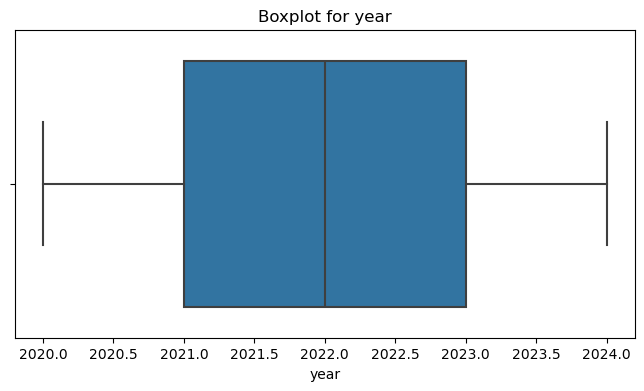

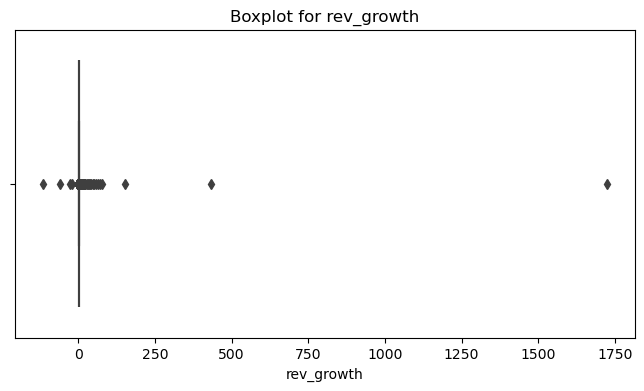

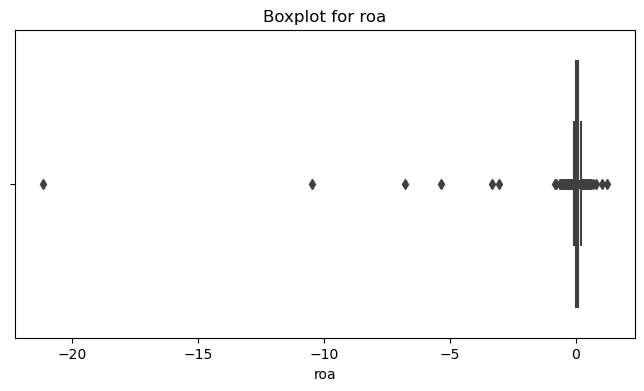

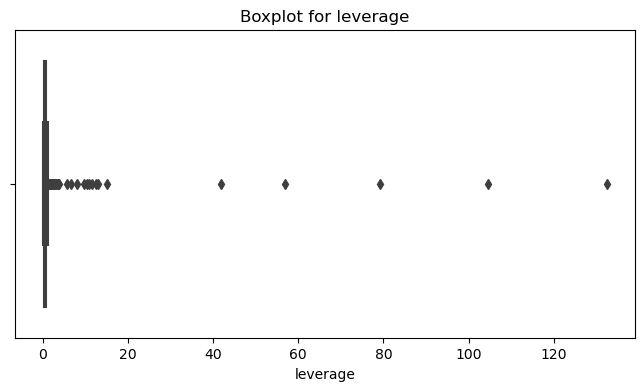

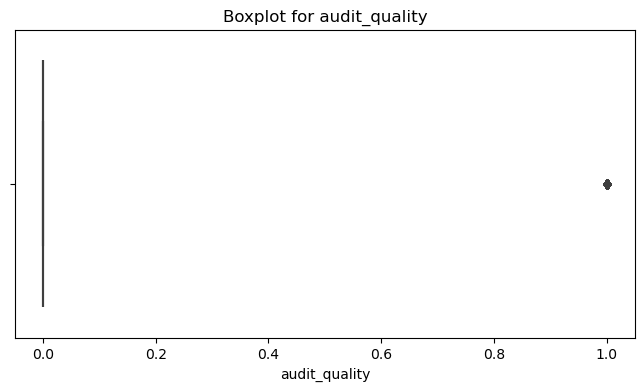

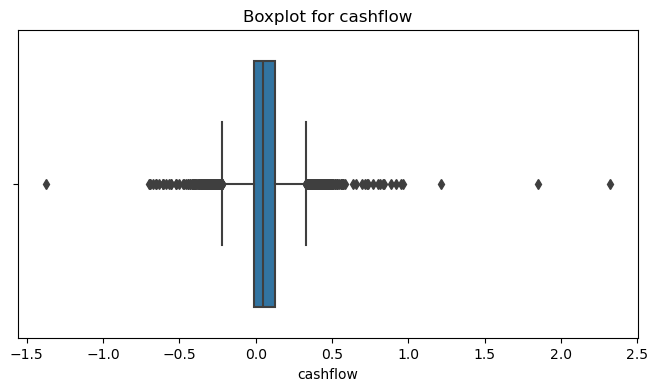

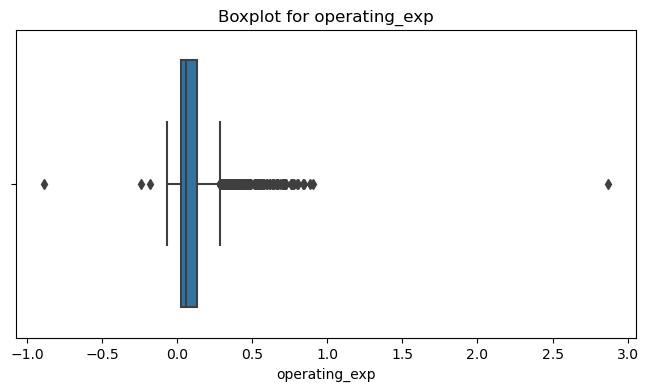

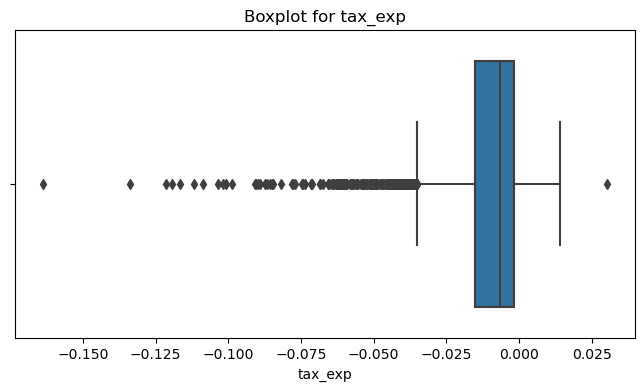

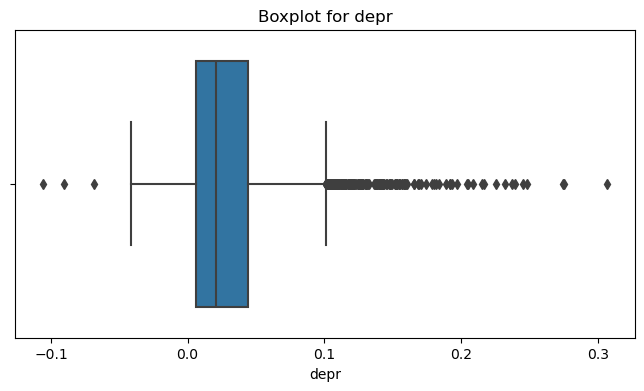

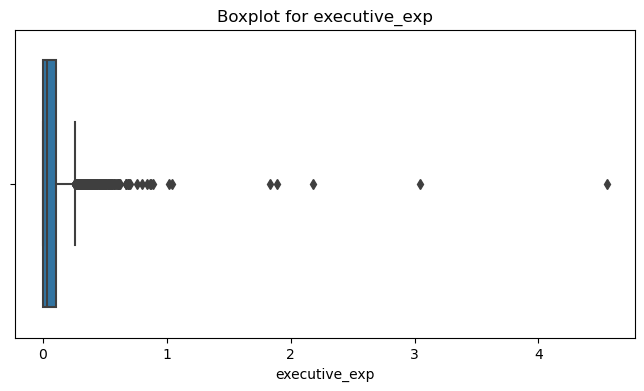

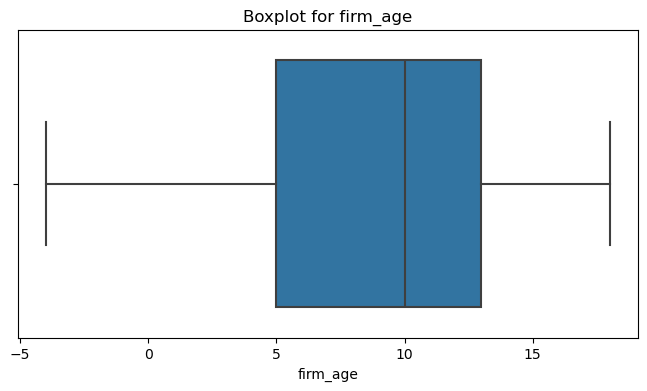

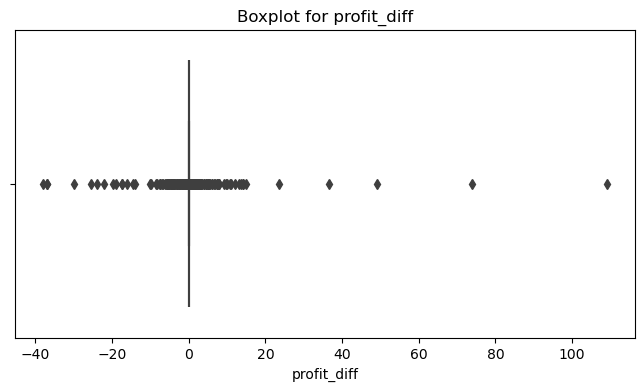

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric columns to check for outliers
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Boxplot for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.xlabel(col)
    plt.show()


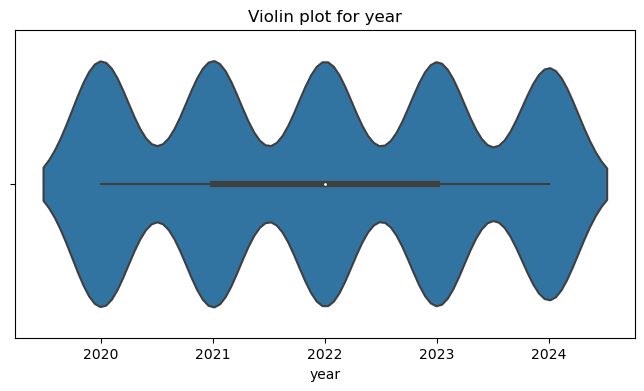

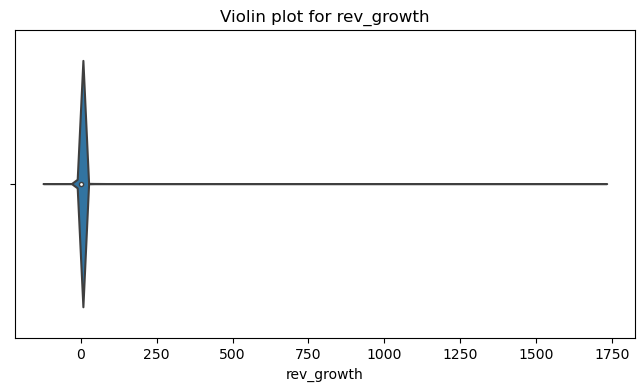

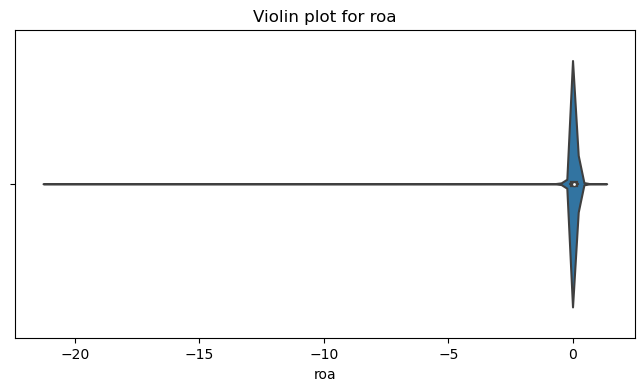

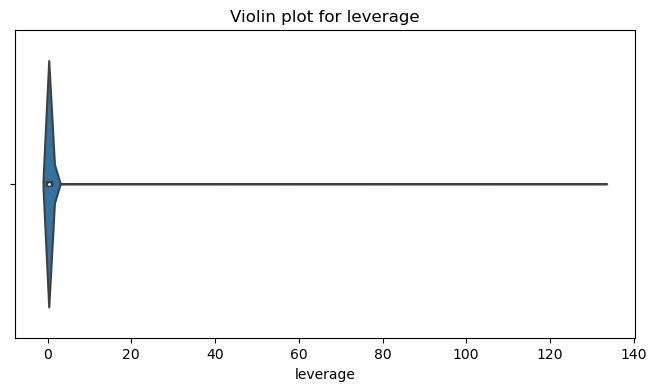

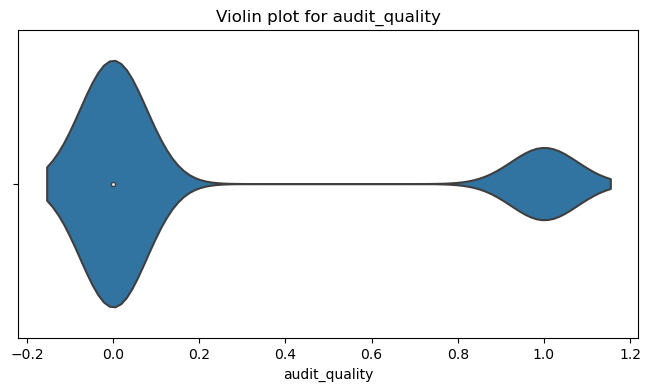

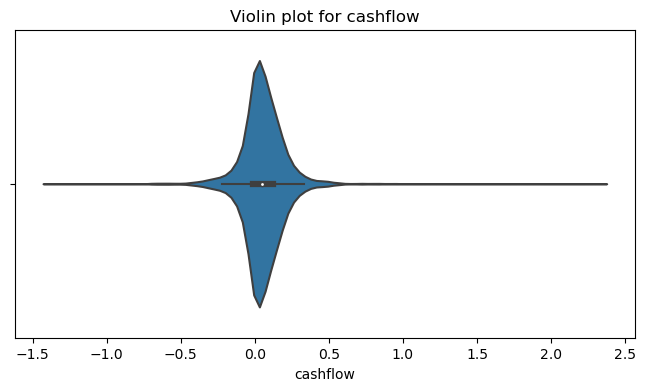

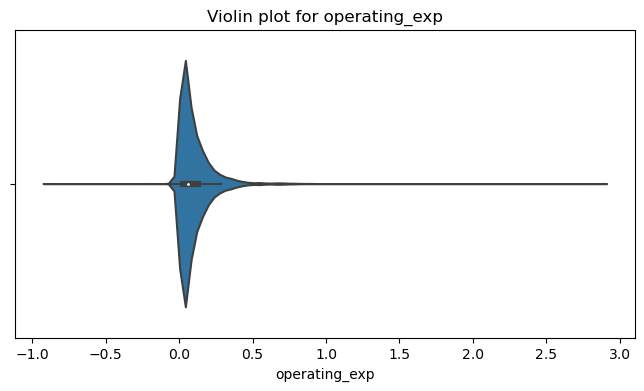

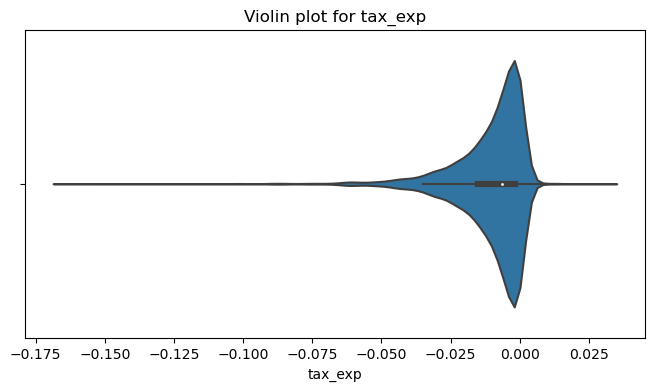

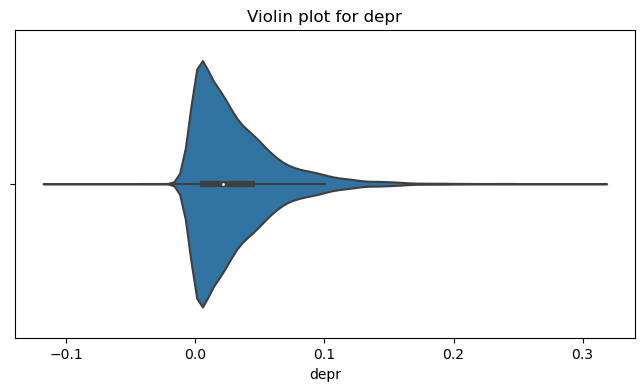

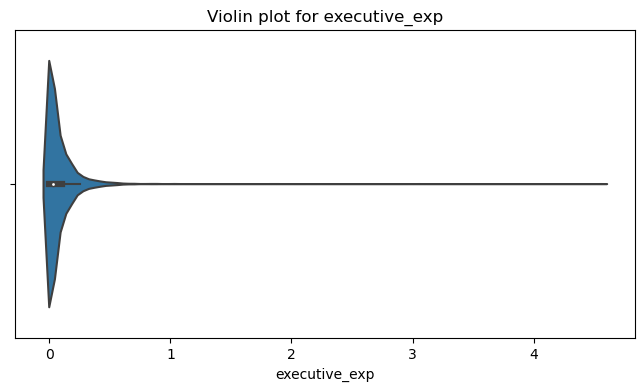

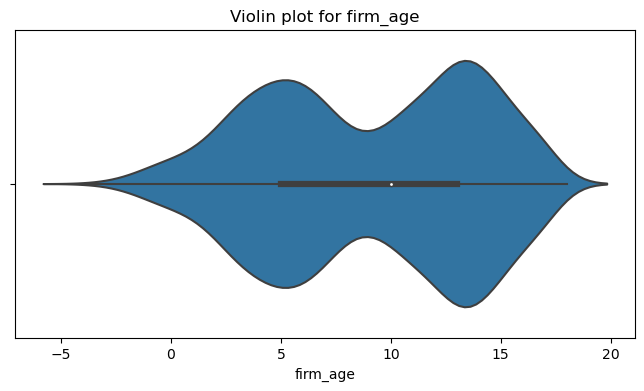

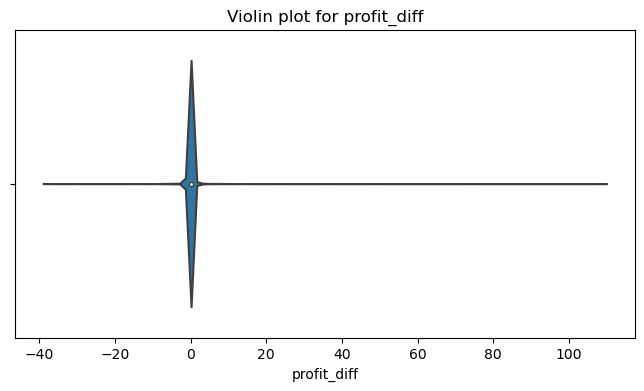

In [34]:
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.violinplot(x=df[col])
    plt.title(f'Violin plot for {col}')
    plt.xlabel(col)
    plt.show()

Overall, there are some outliers, but since the objective is fraud detection, I will keep them as they may indicate fraudulent activity

# Label fraud

Label fraud by 3 methods:
1. Profit difference before and after audit > 5% -> labeled as fraud ("Using random forest and artificial neural network to detect fraudulent financial reporting: Data from listed companies in Vietnam." - Nhien, Hung, & Binh, 2024)
   
2. Auditor opinion is one of the following:
- Chấp nhận từng phần – Ngoại trừ (Qualified opinion)
- Có kiểm toán nhưng thiếu ý kiến kiểm toán (Audited but no opinion provided)
- Từ chối – Không thể đưa ra ý kiến (Disclaimer of opinion)
- Không chấp nhận – Ý kiến trái ngược (Adverse opinion)
-> labeled as fraud ("Predicting financial reports fraud by machine learning: the proxy of auditor opinions" - Nguyen & Phan, 2025)
3. Outlier based on Mahalanobis distance (above Chi-square threshold at 5%) -> labeled as fraud ("Detecting anomalies in financial statements using machine learning algorithm: The case of Vietnamese listed firms." - Lokanan, Tran, & Vuong, 2019)

A firm-year observation is labeled as fraud = 1 if it satisfies at least one of the three criteria (voting 1/3). Otherwise, it is labeled as fraud = 0.

In [35]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

# --- 1. Variables for calculating Mahalanobis Distance ---
features = [
    'rev_growth','roa','leverage','audit_quality', 'audit_change', 'cashflow', 
    'operating_exp', 'tax_exp', 'depr', 'executive_exp', 'firm_age', 'profit_diff'
]

# --- 2. Data Preparation ---
# Select variables, convert to float and fill missing values with mean
X = df[features].astype(float)
X = X.fillna(X.mean())

# Standardize data
X_std = (X - X.mean()) / X.std(ddof=0)

# --- 3. Calculate Mahalanobis Distance ---
# Calculate mean vector and covariance matrix (and inverse)
mean_vec = X_std.mean().values
cov_mat = np.cov(X_std.values, rowvar=False)

# If matrix is near singular, you can add small epsilon to diagonal:
# cov_mat += np.eye(cov_mat.shape[0]) * 1e-6
inv_covmat = np.linalg.inv(cov_mat)

# Function to calculate Mahalanobis Distance
def mahalanobis(u):
    delta = u.values - mean_vec
    return np.sqrt(delta.dot(inv_covmat).dot(delta.T))

# Apply to each row
df['md'] = X_std.apply(mahalanobis, axis=1)

# --- 4. Determine outlier threshold using chi-square ---
p = len(features)         # number of dimensions
alpha = 0.05              # significance level (5%)
threshold = np.sqrt(chi2.ppf(1 - alpha, df=p))
df['md_flag'] = (df['md'] > threshold).astype(int)

# --- 5. Create fraud conditions ---
# 5.1 Profit difference > 5%
cond1 = (df['profit_diff'] > 0.05).astype(int)

# 5.2 Abnormal audit opinion
bad_opinions = [
    'Chấp nhận từng phần - Ngoại trừ',
    'Có kiểm toán nhưng thiếu ý kiến kiểm toán',
    'Từ chối - Không thể đưa ra ý kiến',
    'Không chấp nhận - Ý kiến trái ngược'
]
cond2 = df['audit_opinion'].isin(bad_opinions).astype(int)

# 5.3 Mahalanobis outlier
cond3 = df['md_flag']

# --- 6. Aggregate voting and assign labels ---
# Calculate total votes (3 criteria)
df['vote_sum'] = cond1 + cond2 + cond3

# Assign fraud if >= 2/3 criteria met
df['fraud_flag'] = (df['vote_sum'] >= 1).astype(int)

# Final label: 1 = fraud, 0 = not fraud
df['label'] = df['fraud_flag']

# --- 7. Results Summary ---
print("=== FRAUD DETECTION RESULTS ===")
print(f"MD Threshold: {threshold:.3f}")
print(f"Max MD: {df['md'].max():.3f}")
print(f"Number of MD outliers: {df['md_flag'].sum()}")
print()

print("=== INDIVIDUAL METHOD RESULTS ===")
print(f"Method 1 - Profit Difference > 5%: {cond1.sum()} cases")
print(f"Method 2 - Abnormal Audit Opinion: {cond2.sum()} cases")
print(f"Method 3 - Mahalanobis Outlier: {cond3.sum()} cases")
print()

print("=== VOTING RESULTS ===")
print(f"Total fraud cases (≥1 votes): {df['fraud_flag'].sum()}")
print(f"Fraud rate: {df['fraud_flag'].mean():.2%}")
print()

# print("=== VOTE DISTRIBUTION ===")
# vote_dist = df['vote_sum'].value_counts().sort_index()
# for votes, count in vote_dist.items():
#     print(f"{votes} votes: {count} cases ({count/len(df)*100:.1f}%)")
# print()

# Display sample results
print("=== SAMPLE RESULTS ===")
sample_cols = ['code', 'year', 'profit_diff', 'audit_opinion', 'md', 'vote_sum', 'label']
print(df[sample_cols].head(10))

# Show detailed breakdown of fraud cases
print("\n=== DETAILED FRAUD BREAKDOWN ===")
fraud_cases = df[df['fraud_flag'] == 1]
if len(fraud_cases) > 0:
    print(f"Total fraud cases: {len(fraud_cases)}")
    print("Breakdown by criteria:")
    print(f"  - Profit diff only: {len(fraud_cases[(fraud_cases['vote_sum'] >= 1) & (cond1[fraud_cases.index] == 1)])}")
    print(f"  - Audit opinion only: {len(fraud_cases[(fraud_cases['vote_sum'] >= 1) & (cond2[fraud_cases.index] == 1)])}")
    print(f"  - MD outlier only: {len(fraud_cases[(fraud_cases['vote_sum'] >= 1) & (cond3[fraud_cases.index] == 1)])}")
else:
    print("No fraud cases detected.")

=== FRAUD DETECTION RESULTS ===
MD Threshold: 4.585
Max MD: 66.051
Number of MD outliers: 245

=== INDIVIDUAL METHOD RESULTS ===
Method 1 - Profit Difference > 5%: 553 cases
Method 2 - Abnormal Audit Opinion: 694 cases
Method 3 - Mahalanobis Outlier: 245 cases

=== VOTING RESULTS ===
Total fraud cases (≥1 votes): 1261
Fraud rate: 26.56%

=== SAMPLE RESULTS ===
  code  year  profit_diff        audit_opinion        md  vote_sum  label
0  AAA  2020     0.000000  Chấp nhận toàn phần  2.076151         0      0
1  AAA  2021     0.003096  Chấp nhận toàn phần  1.990251         0      0
2  AAA  2022     0.026316  Chấp nhận toàn phần  2.077696         0      0
3  AAA  2023    -0.006431  Chấp nhận toàn phần  2.545084         0      0
4  AAA  2024     0.032258  Chấp nhận toàn phần  2.250242         0      0
5  AAH  2023    -0.076923  Chấp nhận toàn phần  2.454419         0      0
6  AAH  2024    -0.333333  Chấp nhận toàn phần  2.212299         0      0
7  AAM  2020    -0.000000  Chấp nhận toàn phầ

## Data visualization

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set up style for plot
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [37]:
# Detailed analysis của fraud cases
# Select some important features to visualize
important_features = ['rev_growth', 'roa', 'leverage', 'cashflow', 'profit_diff', 'md']

print("=== DETAILED ANALYSIS OF FRAUD CASES ===")
fraud_cases = df[df['label'] == 1].copy()

if len(fraud_cases) > 0:
    print(f"Total number of fraud cases: {len(fraud_cases)}")
    print(f"Fraud rate: {len(fraud_cases)/len(df)*100:.2f}%")
    print()
    
    # Descriptive statistics for fraud cases
    print("Descriptive statistics for fraud cases:")
    print(fraud_cases[important_features].describe())
    
    # Top companies with highest fraud probability
    if 'code' in df.columns:
        print("\nTop 10 companies at highest risk of fraud:")
        top_fraud = fraud_cases.nlargest(10, 'md')[['code', 'year', 'vote_sum', 'md', 'profit_diff']]
        print(top_fraud.to_string(index=False))
else:
    print("No fraud cases were detected")

=== DETAILED ANALYSIS OF FRAUD CASES ===
Total number of fraud cases: 1261
Fraud rate: 26.56%

Descriptive statistics for fraud cases:
        rev_growth          roa     leverage     cashflow  profit_diff  \
count  1261.000000  1261.000000  1261.000000  1261.000000  1261.000000   
mean      3.124428    -0.030913     0.992846     0.050064     0.186558   
std      50.473929     0.732373     5.657441     0.199354     5.188590   
min    -115.435640   -21.143065     0.002509    -1.373869   -38.000000   
25%       0.851652    -0.024019     0.328001    -0.020094     0.000000   
50%       1.037531     0.008321     0.530071     0.027931     0.001287   
75%       1.229826     0.053628     0.768335     0.101711     0.171429   
max    1723.478139     1.215772   132.462907     2.319517   109.000000   

                md  
count  1261.000000  
mean      3.357110  
std       4.001320  
min       0.957851  
25%       1.748807  
50%       2.540661  
75%       3.635046  
max      66.050830  

Top 10 c

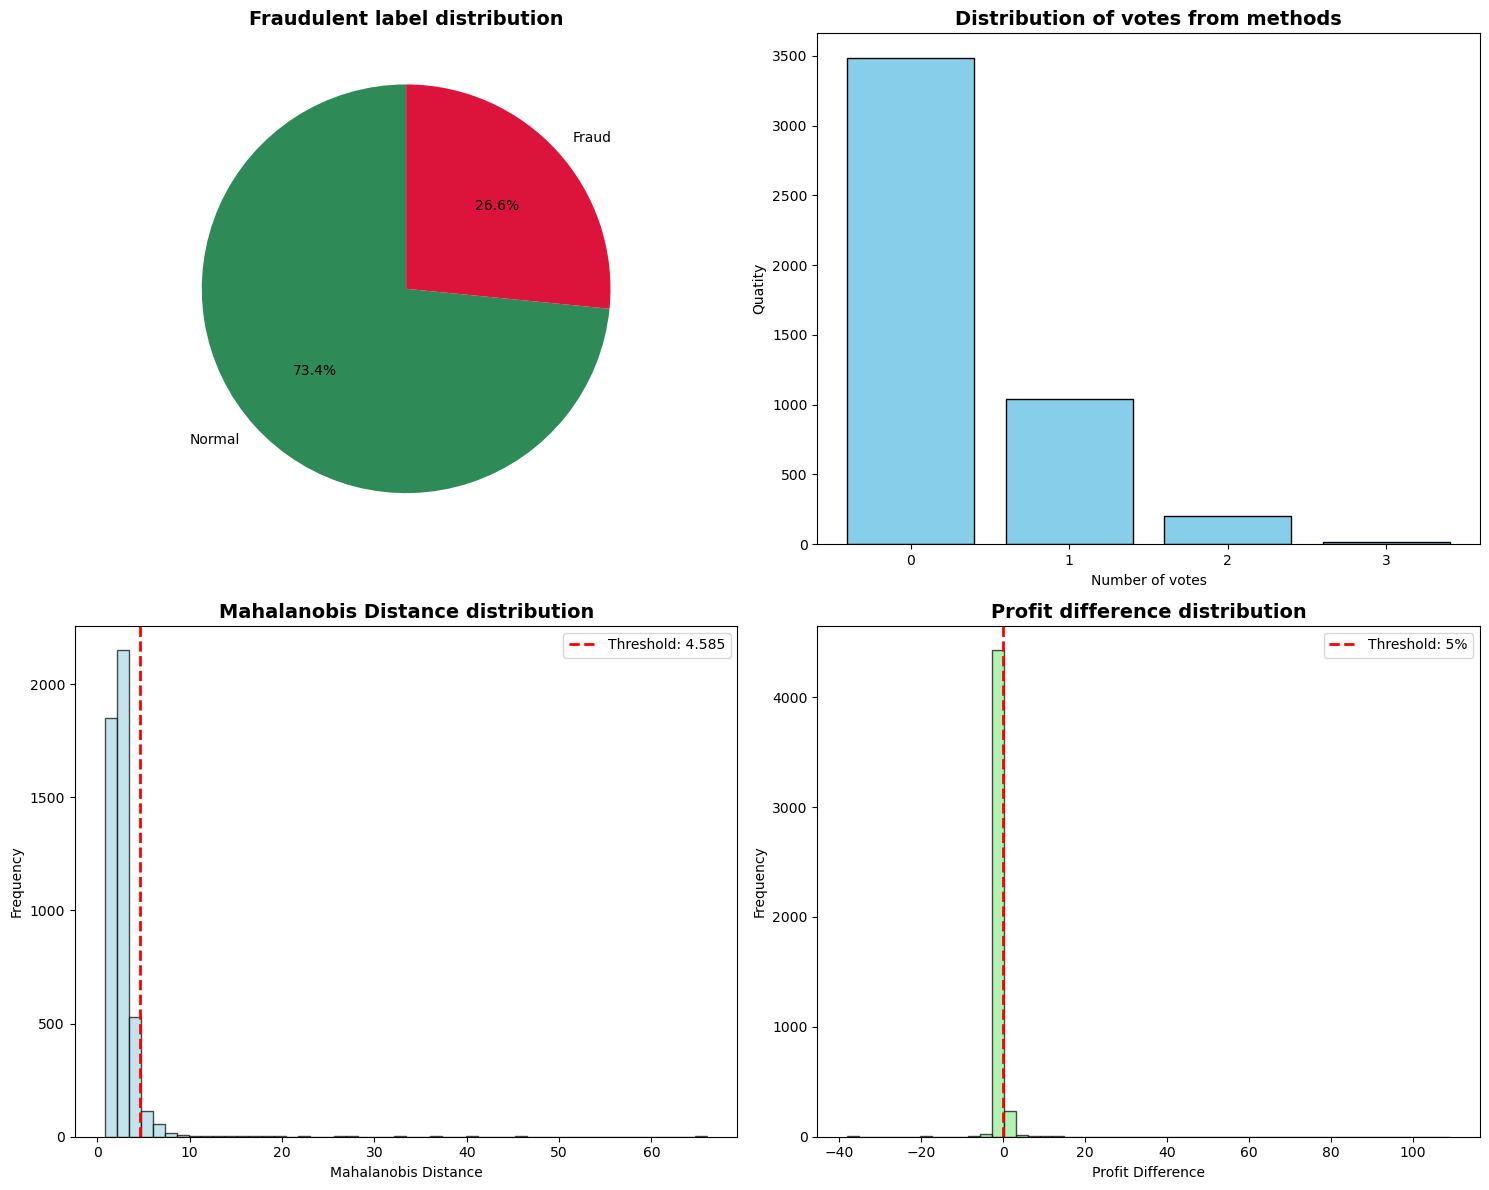

In [38]:
# Overview of fraudulent label distribution
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 2.1 Fraudulent label distribution
fraud_counts = df['label'].value_counts()
colors = ['#2E8B57', '#DC143C']
ax1.pie(fraud_counts.values, labels=['Normal', 'Fraud'], autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax1.set_title('Fraudulent label distribution', fontsize=14, fontweight='bold')

# 2.2 Distribution of votes
vote_counts = df['vote_sum'].value_counts().sort_index()
ax2.bar(vote_counts.index, vote_counts.values, color='skyblue', edgecolor='black')
ax2.set_xlabel('Number of votes')
ax2.set_ylabel('Quatity')
ax2.set_title('Distribution of votes from methods', fontsize=14, fontweight='bold')
ax2.set_xticks(range(int(vote_counts.index.max()) + 1))

# 2.3 Mahalanobis Distance distribution
ax3.hist(df['md'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
ax3.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.3f}')
ax3.set_xlabel('Mahalanobis Distance')
ax3.set_ylabel('Frequency')
ax3.set_title('Mahalanobis Distance distribution', fontsize=14, fontweight='bold')
ax3.legend()

# 2.4 Profit difference distribution
ax4.hist(df['profit_diff'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
ax4.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='Threshold: 5%')
ax4.set_xlabel('Profit Difference')
ax4.set_ylabel('Frequency')
ax4.set_title('Profit difference distribution', fontsize=14, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.show()

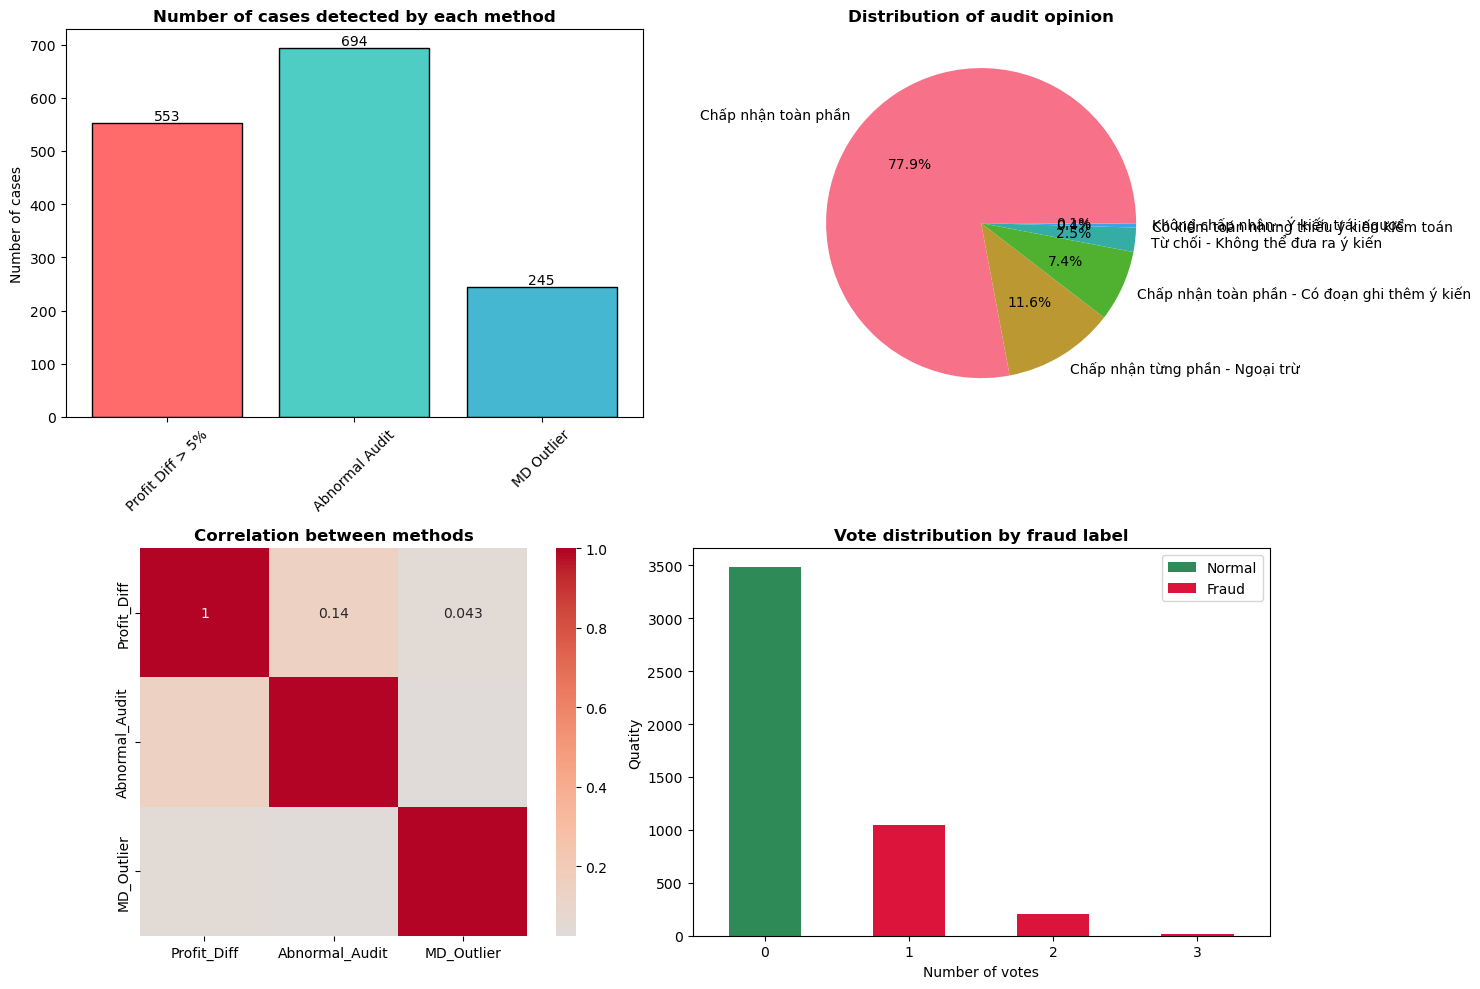

In [39]:
# Analysis of each fraud detection method
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 3.1 Breakdown by detection method
methods = ['Profit Diff > 5%', 'Abnormal Audit', 'MD Outlier']
method_counts = [cond1.sum(), cond2.sum(), cond3.sum()]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

ax = axes[0, 0]
bars = ax.bar(methods, method_counts, color=colors, edgecolor='black')
ax.set_ylabel('Number of cases')
ax.set_title('Number of cases detected by each method', fontsize=12, fontweight='bold')
ax.tick_params(axis='x', rotation=45)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom')

# 3.2 Audit opinion distribution
audit_counts = df['audit_opinion'].value_counts()
ax = axes[0, 1]
ax.pie(audit_counts.values, labels=audit_counts.index, autopct='%1.1f%%')
ax.set_title('Distribution of audit opinion', fontsize=12, fontweight='bold')

# 3.3 Correlation between methods
methods_df = pd.DataFrame({
    'Profit_Diff': cond1,
    'Abnormal_Audit': cond2,
    'MD_Outlier': cond3
})
correlation_matrix = methods_df.corr()
ax = axes[1, 0]
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, ax=ax)
ax.set_title('Correlation between methods', fontsize=12, fontweight='bold')

# 3.4 Vote distribution by fraud label
ax = axes[1, 1]
vote_by_fraud = df.groupby(['vote_sum', 'label']).size().unstack(fill_value=0)
vote_by_fraud.plot(kind='bar', stacked=True, ax=ax, color=['#2E8B57', '#DC143C'])
ax.set_xlabel('Number of votes')
ax.set_ylabel('Quatity')
ax.set_title('Vote distribution by fraud label', fontsize=12, fontweight='bold')
ax.legend(['Normal', 'Fraud'])
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

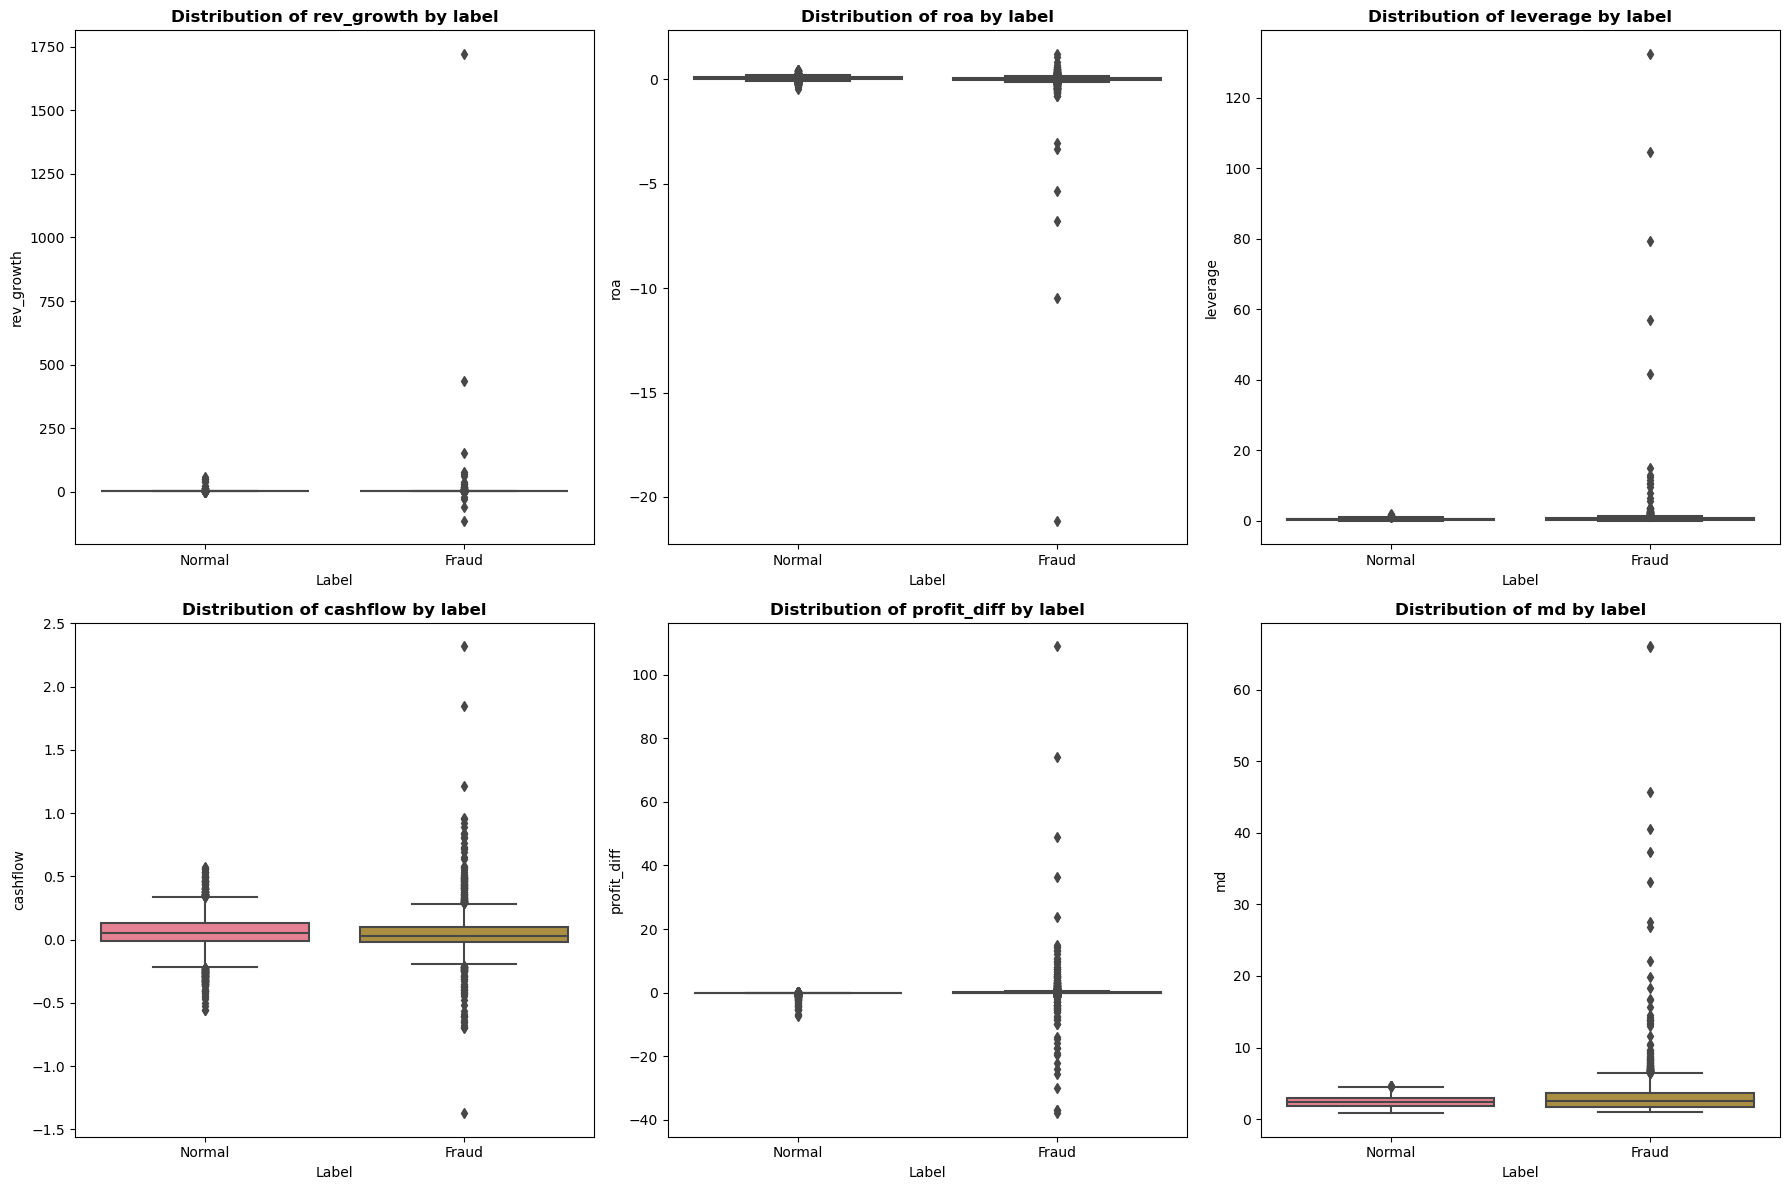

In [40]:
# Fraudulent label feature analysis

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(important_features):
    ax = axes[i]
    
    # Box plot for each feature by fraud label
    df_plot = df[[feature, 'label']].copy()
    df_plot['label'] = df_plot['label'].map({0: 'Normal', 1: 'Fraud'})
    
    sns.boxplot(data=df_plot, x='label', y=feature, ax=ax)
    ax.set_title(f'Distribution of {feature} by label', fontsize=12, fontweight='bold')
    ax.set_xlabel('Label')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()


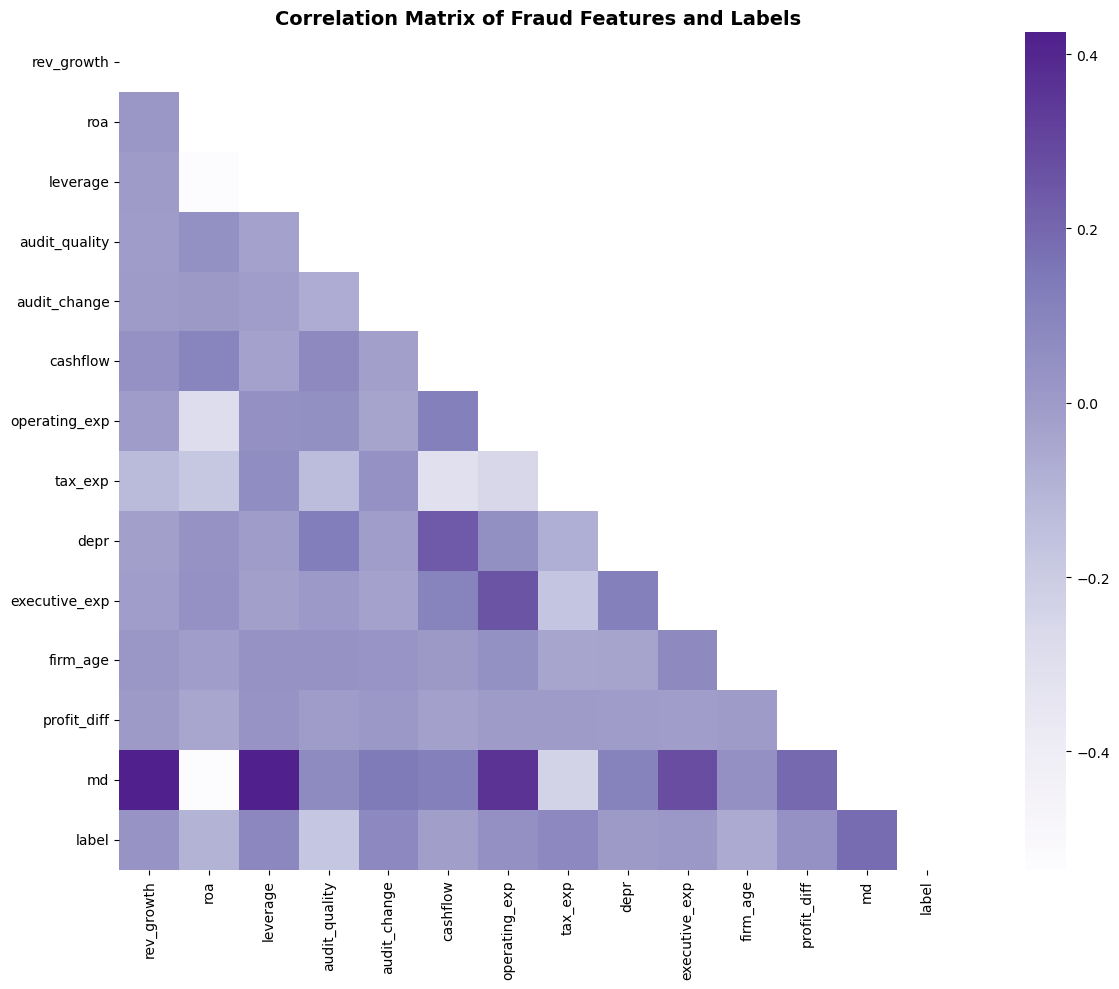

In [41]:
# Heatmap correlation matrix for features
plt.figure(figsize=(14, 10))
features_1  = [
    'rev_growth','roa','leverage','audit_quality', 'audit_change', 'cashflow', 
    'operating_exp', 'tax_exp', 'depr', 'executive_exp', 'firm_age', 'profit_diff'
]
correlation_matrix = df[features_1 + ['md', 'label']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='Purples', 
            center=0, square=True, fmt='.2f')
plt.title('Correlation Matrix of Fraud Features and Labels', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

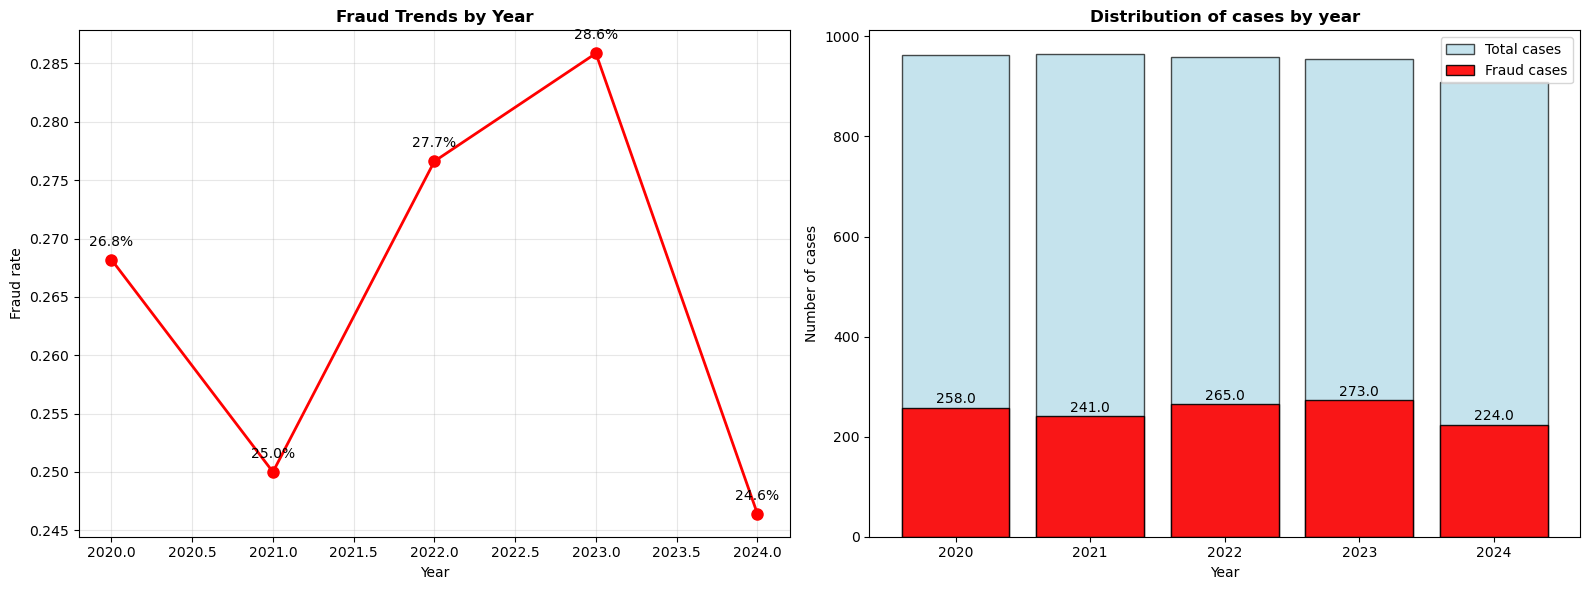

In [42]:
# Fraud cases overtime
if 'year' in df.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 6.1 Fraud trend over years (UPDATED)
    fraud_by_year = df.groupby('year')['label'].agg(['count', 'sum']).reset_index()
    fraud_by_year['fraud_rate'] = fraud_by_year['sum'] / fraud_by_year['count']
    
    ax1.plot(fraud_by_year['year'], fraud_by_year['fraud_rate'], 
             marker='o', linewidth=2, markersize=8, color='red')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Fraud rate')
    ax1.set_title('Fraud Trends by Year', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    for i, row in fraud_by_year.iterrows():
        ax1.annotate(f'{row["fraud_rate"]:.1%}', 
                    (row['year'], row['fraud_rate']),
                    textcoords="offset points", xytext=(0,10), ha='center')
    
    # 6.2 Stacked bar chart: Total vs Fraud cases
    ax2.bar(fraud_by_year['year'], fraud_by_year['count'], 
            alpha=0.7, color='lightblue', edgecolor='black', label='Total cases')
    ax2.bar(fraud_by_year['year'], fraud_by_year['sum'], 
            alpha=0.9, color='red', edgecolor='black', label='Fraud cases')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Number of cases')
    ax2.set_title('Distribution of cases by year', fontsize=12, fontweight='bold')
    ax2.legend()
    
    for i, row in fraud_by_year.iterrows():
        ax2.annotate(f'{row["sum"]}', 
                    (row['year'], row['sum']),
                    textcoords="offset points", xytext=(0,3), ha='center')
    
    plt.tight_layout()
    plt.show()
    

Descriptive analysis reveals that the overall fraud rate is 26.56%, corresponding to 1,261 labeled fraud cases out of 4,748 firm-year observations. Within the fraud group, financial indicators such as leverage and revenue growth show high standard deviations, indicating substantial variability among fraudulent firms. The average Mahalanobis Distance is 3.36, with extreme outliers exceeding 66, suggesting strong structural anomalies. The three detection methods (profit difference > 5%, abnormal audit opinion, Mahalanobis outlier) exhibit low correlation (all < 0.15), highlighting their complementary nature in the voting mechanism. Additionally, the fraud trend fluctuates slightly over the years, peaking in 2023 at 28.6%, which may reflect increased financial misreporting risk during periods of economic uncertainty.


## Model

The machine learning algorithms selected in this study reflect a diverse range of learning capabilities and are based on proven effectiveness in prior research, particularly the foundational study from which this work is extended. Logistic Regression serves as a linear baseline model with clear interpretability. KNN and Naive Bayes are lightweight, non-parametric models well-suited for structured financial data. Decision Tree and Random Forest provide rule-based interpretability and robustness to noise. SVM is included for its ability to handle high-dimensional feature spaces, while ANN and XGBoost represent advanced learners capable of capturing complex non-linear interactions. By incorporating both simple and complex classifiers with varying inductive biases, the study ensures a comprehensive evaluation of model performance in the context of imbalanced and domain-specific financial fraud data.

Key hyperparameters—such as the number of trees in Random Forest, hidden layers and neurons in ANN, and learning rate and max_depth in XGBoost—were carefully tuned to achieve optimal performance on both training and validation sets.


In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Import model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Define features và target
features = ['rev_growth', 'roa', 'leverage', 'audit_quality', 'audit_change', 
           'cashflow', 'operating_exp', 'tax_exp', 'depr', 'executive_exp', 
           'firm_age', 'profit_diff']

X = df[features]
y = df['label'] 

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define model
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'SVM - Linear Kernel': SVC(kernel='linear', random_state=42),
    'SVM - Sigmoid Kernel': SVC(kernel='sigmoid', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Neural Network (ANN)': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=1000),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Function to calculate evaluation metric
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

results = {}

print("Training and evaluating models...")
print("=" * 80)

for name, model in models.items():
    print(f"\nProcessing: {name}")
    
    # Decide whether to use normalized data or not
    if name in ['Logistic Regression', 'k-Nearest Neighbors', 'SVM - Linear Kernel', 
                'SVM - Sigmoid Kernel', 'Neural Network (ANN)']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test
    
    # Model training
    model.fit(X_train_use, y_train)
    
    # Forecast
    y_pred = model.predict(X_test_use)
    
    # Calculate the indexes
    accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred)
    
    # Save the results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

print("\n" + "=" * 80)
print("SUMMARY OF RESULTS:")
print("=" * 80)
print(results_df)

# Find the best model for each metric
print("\n" + "=" * 80)
print("BEST MODEL FOR EACH METRIC:")
print("=" * 80)

for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    best_model = results_df[metric].idxmax()
    best_score = results_df[metric].max()
    print(f"{metric}: {best_model} ({best_score:.4f})")

# Find the overall best model (based on F1-Score)
best_overall = results_df['F1-Score'].idxmax()
print(f"\nOverall best model (according to F1-Score): {best_overall}")

# Best Model Detailed Analysis
print("\n" + "=" * 80)
print(f"DETAILED ANALYSIS OF THE BEST MODEL: {best_overall}")
print("=" * 80)

# Take the best model and retrain it
best_model = models[best_overall]
if best_overall in ['Logistic Regression', 'k-Nearest Neighbors', 'SVM - Linear Kernel', 
                   'SVM - Sigmoid Kernel', 'Neural Network (ANN)']:
    best_model.fit(X_train_scaled, y_train)
    y_pred_best = best_model.predict(X_test_scaled)
else:
    best_model.fit(X_train, y_train)
    y_pred_best = best_model.predict(X_test)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Not Fraud', 'Fraud']))

Training and evaluating models...

Processing: Logistic Regression
Accuracy: 0.7642
Precision: 0.7734
Recall: 0.7642
F1-Score: 0.6979

Processing: k-Nearest Neighbors
Accuracy: 0.7968
Precision: 0.7843
Recall: 0.7968
F1-Score: 0.7772

Processing: Naive Bayes
Accuracy: 0.7895
Precision: 0.8143
Recall: 0.7895
F1-Score: 0.7393

Processing: SVM - Linear Kernel
Accuracy: 0.7463
Precision: 0.8114
Recall: 0.7463
F1-Score: 0.6488

Processing: SVM - Sigmoid Kernel
Accuracy: 0.6358
Precision: 0.6225
Recall: 0.6358
F1-Score: 0.6287

Processing: Decision Tree
Accuracy: 0.8474
Precision: 0.8472
Recall: 0.8474
F1-Score: 0.8473

Processing: Random Forest
Accuracy: 0.9084
Precision: 0.9103
Recall: 0.9084
F1-Score: 0.9040

Processing: Neural Network (ANN)
Accuracy: 0.8726
Precision: 0.8696
Recall: 0.8726
F1-Score: 0.8702

Processing: XGBoost
Accuracy: 0.9011
Precision: 0.8996
Recall: 0.9011
F1-Score: 0.8980

SUMMARY OF RESULTS:
                      Accuracy  Precision  Recall  F1-Score
Logistic Regres

The results indicate that Random Forest outperformed all other models, achieving the highest performance across all key metrics: Accuracy = 90.84%, Precision = 91.03%, Recall = 90.84%, and F1-score = 90.40%. Notably, the model maintained a strong balance between precision and recall, demonstrating robust capability in distinguishing between fraudulent and non-fraudulent cases. According to the detailed classification report, Random Forest achieved a recall of 93% for fraudulent cases and 98% for non-fraudulent ones, reflecting its strong effectiveness in fraud detection with minimal false negatives.

## Evaluate model

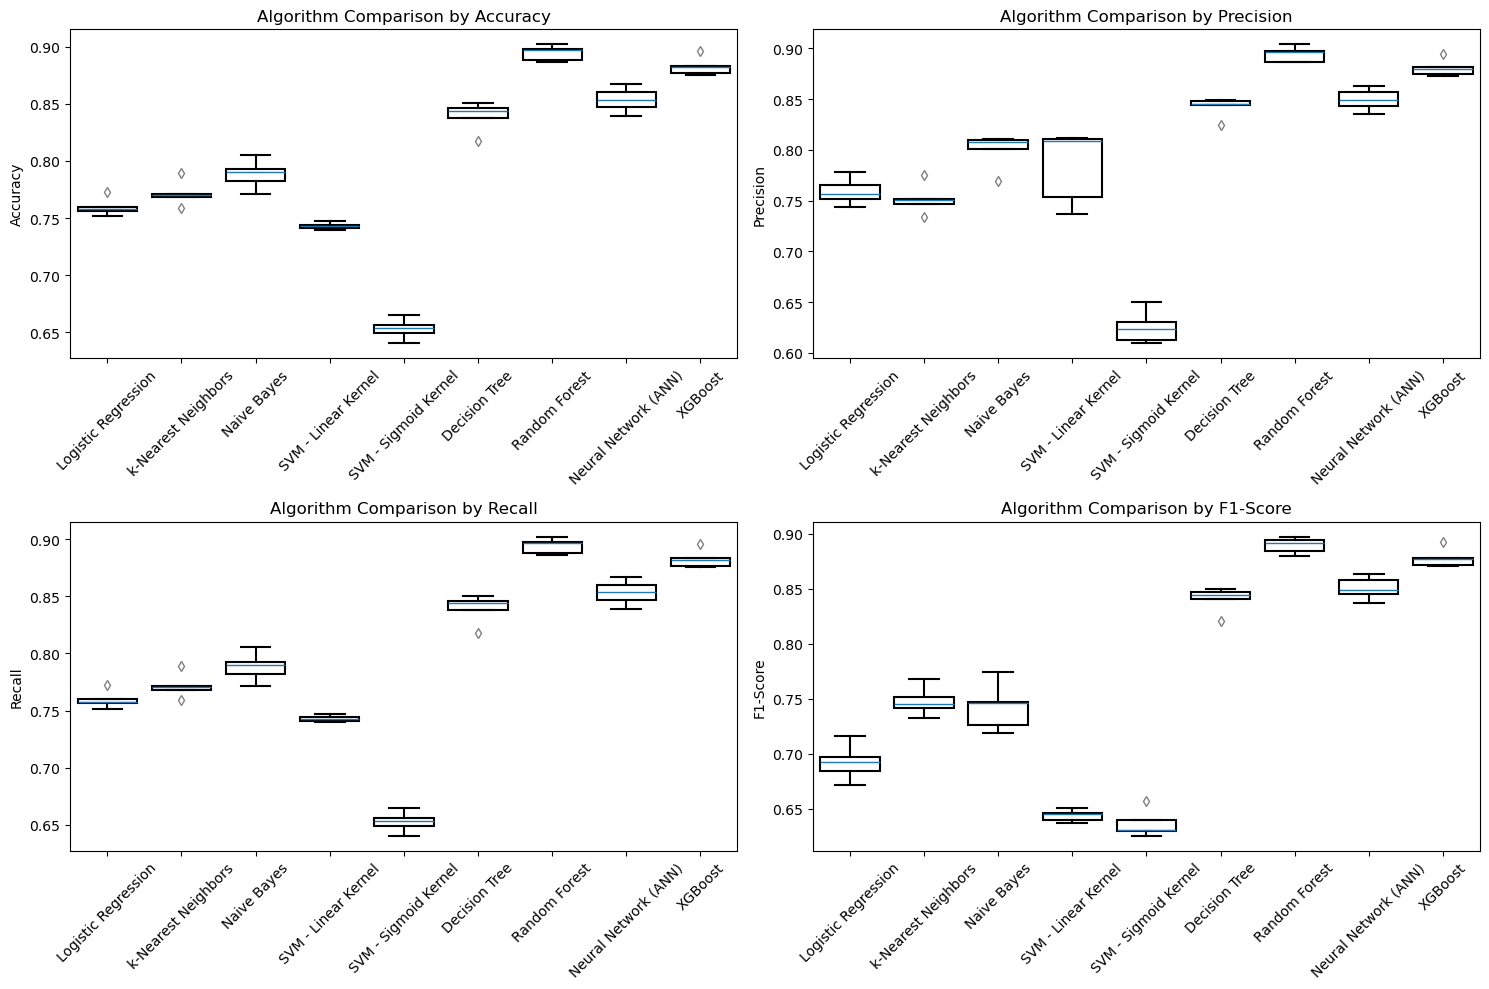

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Define metrics and their scoring names
metrics = {
    'Accuracy':        'accuracy',
    'Precision':       'precision_weighted',
    'Recall':          'recall_weighted',
    'F1-Score':        'f1_weighted'
}

# Collect CV results
cv_records = []
for name, model in models.items():
    # wrap scaler for certain models
    if name in ['Logistic Regression', 'k-Nearest Neighbors',
                'SVM - Linear Kernel', 'SVM - Sigmoid Kernel',
                'Neural Network (ANN)']:
        estimator = make_pipeline(StandardScaler(), model)
    else:
        estimator = model

    for metric_name, scoring in metrics.items():
        scores = cross_val_score(estimator, X, y, cv=5, scoring=scoring)
        for s in scores:
            cv_records.append({
                'Model':  name,
                'Metric': metric_name,
                'Score':  s
            })

cv_df = pd.DataFrame(cv_records)

# Plot in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for ax, metric_name in zip(axes, metrics.keys()):
    sns.boxplot(
        data=cv_df[cv_df['Metric'] == metric_name],
        x='Model', y='Score', ax=ax,
        boxprops={'facecolor': 'none', 'edgecolor': 'black'},
        whiskerprops={'color': 'black'},
        capprops={'color': 'black'},
        medianprops={'color': '#1f77b4', 'linewidth': 1},
        flierprops={'markerfacecolor': 'none', 'markeredgecolor': 'grey'}
    )
    ax.set_title(f'Algorithm Comparison by {metric_name}')
    ax.set_xlabel('')
    ax.set_ylabel(metric_name)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


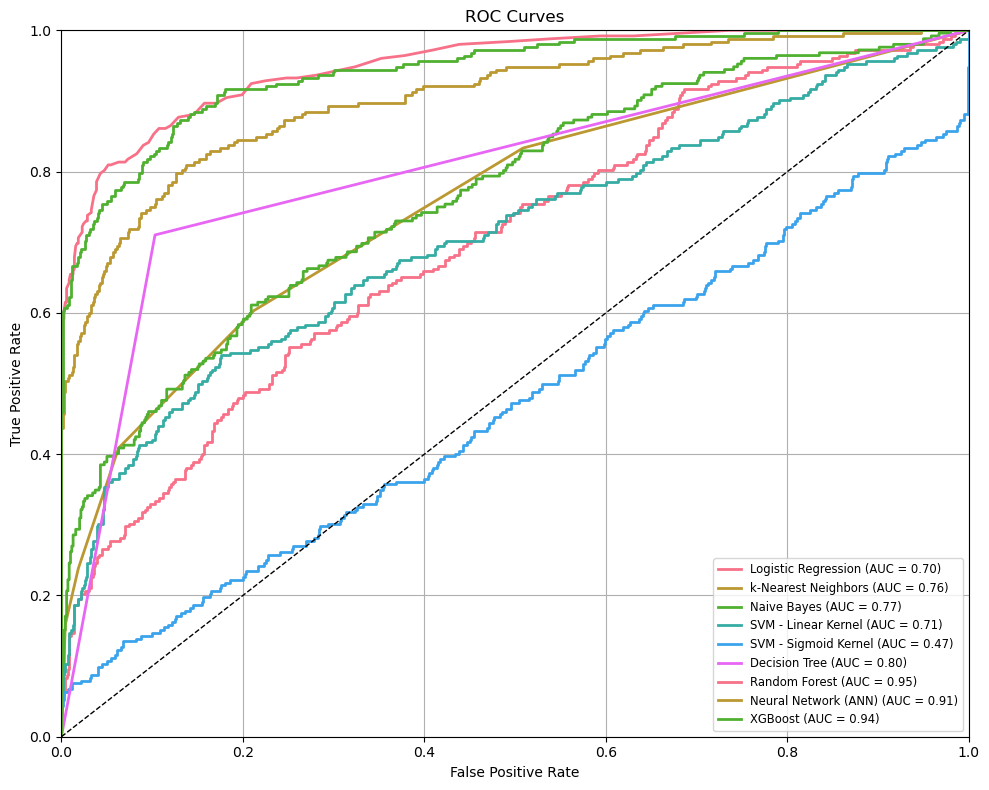

In [45]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Define which models need scaling
to_scale = [
    'Logistic Regression', 'k-Nearest Neighbors',
    'SVM - Linear Kernel', 'SVM - Sigmoid Kernel',
    'Neural Network (ANN)'
]

for name, model in models.items():
    # wrap in a pipeline if scaling is required
    if name in to_scale:
        clf = make_pipeline(StandardScaler(), model)
        X_tr, X_te = X_train, X_test
    else:
        clf = model
        X_tr, X_te = X_train, X_test

    # fit on training data
    clf.fit(X_tr, y_train)

    # get scores: use predict_proba if available, else decision_function
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_te)[:, 1]
    else:
        y_score = clf.decision_function(X_te)

    # compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # plot
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

# plot random chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


Analyzing Random Forest Feature Importance...

Feature Importance Statistics:
Most important feature: profit_diff (0.3620)
Least important feature: audit_change (0.0071)
Average importance: 0.0833
Standard deviation: 0.0931


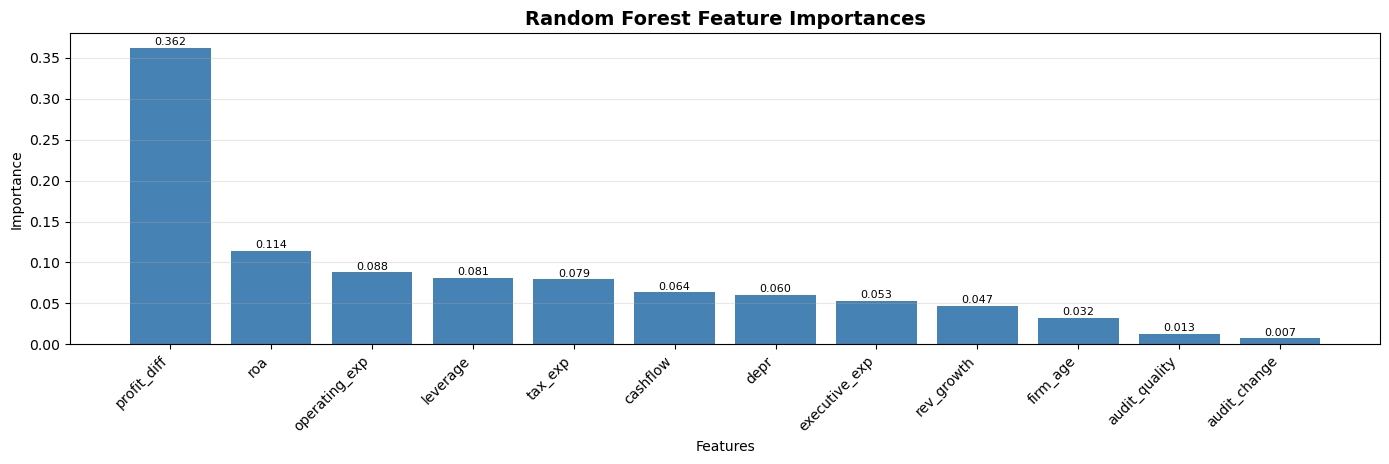

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


rf_model = models['Random Forest']

print("Analyzing Random Forest Feature Importance...")
print("=" * 50)

# Get feature importance
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Visualization Bar plot for feature importance in Random Forest
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
bars = plt.bar(range(len(importance_df)), importance_df['Importance'], color='steelblue')
plt.title('Random Forest Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(range(len(importance_df)), importance_df['Feature'], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()

# Additional statistics on feature importance
print(f"\nFeature Importance Statistics:")
print("=" * 40)
print(f"Most important feature: {importance_df.iloc[0]['Feature']} ({importance_df.iloc[0]['Importance']:.4f})")
print(f"Least important feature: {importance_df.iloc[-1]['Feature']} ({importance_df.iloc[-1]['Importance']:.4f})")
print(f"Average importance: {importance_df['Importance'].mean():.4f}")
print(f"Standard deviation: {importance_df['Importance'].std():.4f}")


## Discussion
Compared to the previous study which assessed financial statement fraud using only individual criteria like M-Score and auditor opinion, our research applies a more robust and comprehensive labeling method by combining multiple fraud detection indicators (profit difference, auditor opinion, Mahalanobis Distance) through a voting-based approach. This enhancement addresses the limitation of label bias when relying solely on a single metric and improves the reliability of the classification task.

The performance metrics of our models (Figures 1 & 2) consistently outperform those in the prior study (Figures 3 to 6) across accuracy, precision, recall, F1-score, and AUC-ROC. Specifically, the Random Forest model achieved superior results in all four key metrics and an AUC of 0.95, compared to only 0.83 (M-Score) and 0.74 (Auditor opinion) in the reference study. Furthermore, the reduced variance across cross-validation folds in our plots suggests better generalizability and model stability.

This improvement can be attributed not only to our labeling strategy but also to the rigorous hyperparameter tuning, the balanced dataset splitting strategy, and the comprehensive evaluation framework using multiple metrics. In contrast, the earlier study exhibits inconsistent classifier performance under different fraud labeling schemes and higher performance variance.

Also,  Feature Importance in Random Forest reveals that profit difference (profit_diff) is by far the most influential predictor in detecting fraud, contributing over 36% to the model’s decisions. This aligns with the economic intuition that significant profit discrepancies pre- and post-audit often signal earnings manipulation. Other important features include ROA, operating expenses, leverage, and tax expense, which reflect key aspects of profitability, efficiency, and financial structure that firms may alter to distort performance. Interestingly, audit-related variables such as audit quality and audit change contribute less, suggesting that internal firm-level metrics hold stronger predictive power in the Vietnamese context.